# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import pickle

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

### Exercise 3.4: Basic statistics

First, we will look at basic statistics on this dataset.

- Plot the number of ratings for each user.
- Plot the number of ratings for each item.

Is the number of ratings balanced uniformly across users and movies?

#### Distribution of users

In [4]:
user_rating = data.map(lambda x: (x['userId'], x['rating']))

user_counts = list(user_rating.countByKey().items())
u_counts = sorted([x[1] for x in user_counts])

print("There are {} users".format(len(user_counts)))

There are 138493 users


#### Distribution of movies

In [5]:
movie_rating = data.map(lambda x: (x['movieId'], x['rating']))

movie_counts = list(movie_rating.countByKey().items())
m_counts = sorted([x[1] for x in movie_counts])

print("There are {} movies".format(len(movie_counts)))

There are 26744 movies


### Plots

In [6]:
u_cum = np.cumsum(u_counts)
m_cum = np.cumsum(m_counts)

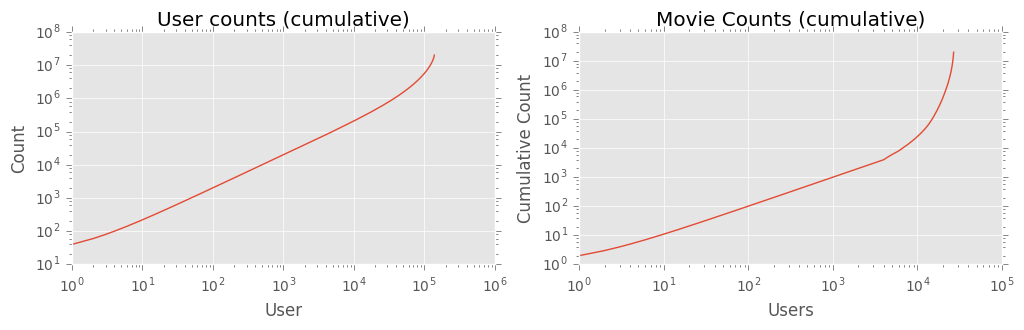

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))

ax1.plot(u_cum)
ax1.set_title("User counts (cumulative)")
ax1.set_xlabel('User')
ax1.set_ylabel('Count')

ax2.plot(m_cum)
ax2.set_title("Movie Counts (cumulative)")
ax2.set_xlabel('Users')
ax2.set_ylabel('Cumulative Count')

ax2.loglog()
ax1.loglog()

plt.show()

We observe that the ratings are not evenly distributed: there is a long tail of movies and users with few ratings, and a few with lots of ratings.

### Exercise 3.5 Partitioning the dataset

We start by reading in our own ratings, and adding this to a c

In [8]:
with open('/home/aurlien/labs/ix-lab3/my-ratings.txt') as f:
    my_ratings = sc.parallelize([json.loads(line) for line in f.read().splitlines()])

my_ratings.first()

{'movieId': 1, 'rating': 1, 'timestamp': 1494171590, 'userId': 138494}

In [9]:
# Append your personal ratings to the MovieLens dataset RDD.
data_concat = data.union(my_ratings)

In [10]:
# Formated RDD with all data, for later use

all_data = data_concat.map(lambda x: (x['userId'], x['movieId'], x['rating']))

We partition the data into two sets: ≈ 80% for training, and ≈ 20% for validation

In [11]:
training = data_concat.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))
test = data_concat.filter(lambda x: (x['timestamp'] % 10) <= 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))

In [12]:
# Take a look at the training set ...
training.take(10)

[(1, 2, 3.5),
 (1, 29, 3.5),
 (1, 32, 3.5),
 (1, 47, 3.5),
 (1, 151, 4.0),
 (1, 223, 4.0),
 (1, 260, 4.0),
 (1, 293, 4.0),
 (1, 296, 4.0),
 (1, 318, 4.0)]

In [13]:
# And the test set
test.take(10)

[(1, 50, 3.5),
 (1, 112, 3.5),
 (1, 253, 4.0),
 (1, 367, 3.5),
 (1, 593, 3.5),
 (1, 653, 3.0),
 (1, 919, 3.5),
 (1, 1036, 4.0),
 (1, 1097, 4.0),
 (1, 1193, 3.5)]

In [14]:
train_size = training.count()
test_size = test.count()

In [15]:
tot = train_size + test_size

In [16]:
print("Train size: {} ({:.4f})".format(train_size, train_size / tot))
print("Test size: {} ({:.4f})".format(test_size, test_size / tot))

Train size: 15999981 (0.8000)
Test size: 4000291 (0.2000)


## Baseline recommender system

- prediction
$${\hat{r}}_{um} = \mu + \alpha_{u} + \beta_{m}$$

- global average rating:
    $$\mu = \frac{1}{N} \sum\limits_{u,m}r_{um}$$
    
- user bias:
    $$\alpha_{u} = \frac{1}{N_{u}} \sum\limits_{m} (r_{um} - \mu)$$
    
- item bias:
    $$\beta_{m} = \frac{1}{N_m} \sum\limits_{u}(r_{um} - \alpha_{u} - \mu)$$

### 3.6 Baseline model

We compute the global mean, the user biases and the item biases based on the training set:

In [17]:
mu = training.map(lambda x: x[2]).mean()
mu

3.5255072177898263

In [18]:
# Inspired by: http://stackoverflow.com/questions/29930110/calculating-the-averages-for-each-key-in-a-pairwise-k-v-rdd-in-spark-with-pyth
def mean_by_key(rdd):
    """
    Input:
    - rdd is a spark RDD considering of (key, value) pairs.
    
    Output:
    - An RDD of (key, value) pairs where the keys are the keys from the RDD, and
      the value is the mean value for that key. 
    """
    return (rdd.aggregateByKey((0,0),
                              lambda a,b: (a[0] + b,    a[1] + 1),
                              lambda a,b: (a[0] + b[0], a[1] + b[1]))
            .mapValues(lambda v: v[0]/v[1]))

In [19]:
user_biases = mean_by_key(training.map(lambda x: (x[0], x[2] - mu))).collectAsMap()

In [20]:
def dict_sample(a_dict, sample):
    return dict(list(a_dict.items())[:sample])

In [21]:
dict_sample(user_biases, 5)

{1: 0.23335803043712403,
 2: 0.4360312437486352,
 3: 0.5565823344489818,
 4: 0.14115944887684032,
 5: 0.8707191973045139}

In [22]:
def mean_value(D):
    """
    Input:
    - A dictionary D
    Output:
    - The mean of all values in the dictionary
    """
    return np.mean([D[key] for key in D])

In [23]:
mean_user_bias = mean_value(user_biases)
mean_user_bias

0.10160528196622429

In [24]:
item_biases = mean_by_key(
    training.map(lambda x: (x[1], x[2] - user_biases[x[0]] - mu))
).collectAsMap()

In [25]:
dict_sample(item_biases, 5)

{1: 0.31478351532531934,
 2: -0.30951623486223523,
 3: -0.35562033927476083,
 4: -0.6073047711237985,
 131072: -1.2135535307517116}

In [26]:
mean_item_bias = mean_value(item_biases)
mean_item_bias

-0.20496287589087514

In [27]:
def user_bias(userId):
    if userId in user_biases.keys():
        return user_biases[userId]
    
    return mean_user_bias

def item_bias(movieId):
    if movieId in item_biases.keys():
        return item_biases[movieId]
    
    return mean_item_bias

In [28]:
def predict(user, movie):
    return ((user, movie), mu + user_bias(user) + item_bias(movie))

In [29]:
def predict_all(user_movie):
    return user_movie.map(lambda x: predict(x[0], x[1]))

In [30]:
test.first()

(1, 50, 3.5)

In [31]:
user_movie = test.map(lambda x: (x[0], x[1]))

In [32]:
user_movie.first()

(1, 50)

In [33]:
predictions = predict_all(user_movie)

In [34]:
test.take(10)

[(1, 50, 3.5),
 (1, 112, 3.5),
 (1, 253, 4.0),
 (1, 367, 3.5),
 (1, 593, 3.5),
 (1, 653, 3.0),
 (1, 919, 3.5),
 (1, 1036, 4.0),
 (1, 1097, 4.0),
 (1, 1193, 3.5)]

In [35]:
# (userId, movieId, prediction)
predictions.take(10)

[((1, 50), 4.467954194198161),
 ((1, 112), 3.6885060426375786),
 ((1, 253), 3.721645368228365),
 ((1, 367), 3.3938553801249567),
 ((1, 593), 4.302769002501194),
 ((1, 653), 3.4672721366276336),
 ((1, 919), 4.12564723198807),
 ((1, 1036), 4.100066677848259),
 ((1, 1097), 3.9209700868942208),
 ((1, 1193), 4.352077055355451)]

### Evaluation

$$e = \frac{1}{U} \sum\limits_{u}\sqrt{\frac{1}{N_{u}} \sum\limits_{m}(\hat{r}_{um} - r_{um})^{2}}$$

In [36]:
def error(preds):
    """
    Input: 
    - preds: RDD of ((user, movie), prediction)
    Output:
    - err: the average root mean square errors over the users
    """
    
    ranks_and_preds = test.map(lambda x: ((x[0], x[1]), x[2])).join(preds)
    
    err = mean_by_key(
                ranks_and_preds.map(lambda t: (t[0][0], (t[1][0] - t[1][1]) ** 2))
            ).map(lambda u: np.sqrt(u[1])).mean()
    
    return err

In [37]:
print('Average rmse over users for baseline model: ', error(predictions))

Average rmse over users for baseline model:  0.868372959892


## Matrix-factorization model

Inspired by: [www.codementor.io](https://www.codementor.io/jadianes/building-a-recommender-with-apache-spark-python-example-app-part1-du1083qbw)

- Decide on a rank for your model, e.g., between 5 and 25. What is the trade-off between choosing a lower and a higher rank?

- Set the regularization parameter lambda_ to 10−4. How accurate are the predicted ratings? Can you explain the phenomenon?

- Now set lambda_ to 10.0. What happens to the predicted ratings, and why?
- Find the value of lambda_ that minimizes the validation error.
- What improvement do you get over the error of the baseline recommender system?

In [38]:
from pyspark.mllib.recommendation import ALS

#### Choise of rank:
The rank of the model decides how many latent factors that the model will use. A low rank gives a simpler model that will be quicker to train (less parameters to learn), while a higher rank gives more expressiveness to the model. However, with the higher expressiveness comes the possibility of overfitting.

We choose to work with a rank of 10.

In [39]:
rank = 10

### 3.8 Regularization

The regularization parameter affects the balance between simplicity and expressiveness of our models. A too low value of lambda can lead to a model that overfits to the training data, while a too low value can penalize the model such that it looses expressiveness.

We start by using a low regularization parameter of $10^{-4}$:

In [40]:
lamb_1 = 10e-4
model_1 = ALS.train(training, rank, lambda_=lamb_1)
preds_1 = model_1.predictAll(user_movie).map(lambda x: ((x[0], x[1]), x[2]))

In [41]:
err_1 = error(preds_1)
print('Average rmse over users for Matrix-factorization model with lambda=10^-4: ', err_1)

Average rmse over users for Matrix-factorization model with lambda=10^-4:  0.852125310147


Observe that this model perfomes quite a bit better than our baseline model.
We continue with the relatively high regularization parameter of 10.0:

In [42]:
lamb_2 = 10.0

model_2 = ALS.train(training, rank=rank, lambda_=lamb_2)
preds_2 = model_2.predictAll(user_movie).map(lambda x: ((x[0], x[1]), x[2]))

In [43]:
err_2 = error(preds_2)
print('Average rmse over users for Matrix-factorization model with lambda=10.0: ', err_2)

Average rmse over users for Matrix-factorization model with lambda=10.0:  3.74686507746


For our rank 10 model this is clearly too high, and we end up with a much higher average RMSE compared to our baseline model.

We expect that the optimal lamba lays somewhere in between the values we have already tried. To find an optimal value, we perform a grid search in the logaritmic scale:

In [44]:
lambdas = [10.0**i for i in range(-2,1,1)]
lambdas

[0.01, 0.1, 1.0]

In [45]:
errors = []
models = []

for lamb in lambdas:
    model = ALS.train(training, rank, lambda_=lamb)
    preds = model.predictAll(user_movie).map(lambda x: ((x[0], x[1]), x[2]))
        
    err = error(preds)
    errors.append(err)

In [46]:
for model, (err, lamb) in enumerate(zip(errors, lambdas)):
    print("Model {}, using lambda {}, had error {}.".format(model, lamb, err))

Model 0, using lambda 0.01, had error 0.8367149794069872.
Model 1, using lambda 0.1, had error 0.8175627126431.
Model 2, using lambda 1.0, had error 1.330382283451674.


In [47]:
best_model = np.argsort(errors)[0]
best_model

1

In [48]:
lamb_opt = lambdas[best_model]
print('We found the optimal lambda to be {}'.format(lamb_opt))

We found the optimal lambda to be 0.1


In [49]:
err_best = errors[best_model]
err_baseline = 0.868365849541

In [50]:
diff = err_baseline - err_best
improvement = diff / err_baseline * 100
improvement

5.8504300836742402

Comparing to our baseline, we can see that the average RMSE over users has gone down from ~0.868 to ~0.818, an imporovement of about 5.8%

## Recomendation

> Create a Python dict that maps from movie IDs to movie titles based on the file movies.txt.
> - Recommend10moviesforuser123usingmodel.recommendProducts().Whatkind of movies does the model think the user will like?
> - Recommend 10 movies to yourself (user ID: 138494)
  
> What do you think of your recommendations? :-)

We first train a model on all the data, using the best parameters found in the previous steps:

In [51]:
model = ALS.train(all_data, rank=8, lambda_=0.1)

Then we load the selected movies from the textfile, and transform it into a map from MovieId to MovieName:

In [52]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movie_to_title = movies.map(itemgetter("movieId", "title")).collectAsMap()

In [53]:
dict_sample(movie_to_title, 5)

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 131072: 'Jesus liebt mich (2012)'}

We are now ready to make recommendations for user:

In [54]:
Rating = {'user': 0, 'product': 1, 'rating': 2}

In [55]:
def recomend_for_user(userId, n):
    """ Given a userId, give back the n top rated movies.
    """
    recomendations = model.recommendProducts(userId, n)
    movie_ids = [rating[Rating['product']] for rating in recomendations]
    movies = [movie_to_title[movie_id] for movie_id in movie_ids]
    return movies

Starting with the user 123, we get the following 10 movies recommended:

In [56]:
given_user = 123
recomend_for_user(given_user, 10)

['My Brother Tom (2001)',
 'Bill Hicks: Sane Man (1989)',
 'I Belong (Som du ser meg) (2012)',
 'Doggiewoggiez! Poochiewoochiez! (2012)',
 'Moth, The (Cma) (1980)',
 "It's Love I'm After (1937)",
 'Flight of the Conchords: A Texan Odyssey (2006)',
 'Hellhounds on My Trail (1999)',
 'Stuart: A Life Backward (2007)',
 'Sierra, La (2005)']

For our user, theese are the movies that we are recomended:

In [57]:
our_user = 138494
recomend_for_user(our_user, 10)

['Marihuana (1936)',
 'Bela Kiss: Prologue (2013)',
 'Dirty Bomb (2011)',
 "2016: Obama's America (2012)",
 "You Can't Win 'Em All (1970)",
 'Conqueror, The (1956)',
 'Code Name Coq Rouge (1989)',
 'Homeboy (1988)',
 'Crazy Stone (Fengkuang de shitou) (2006)',
 'She Creature (Mermaid Chronicles Part 1: She Creature) (2001)']

We are not very impressed by the recomendations, but as whe have not seen all of these movies, we are willing to give the system the benefit of the doubt.

### 3.10 Visualization

Learn a rank-2 matrix-factorization model using ALS().
- Extract the features for all the movies in selected-movies.pickle.
- Create an interactive plot that embeds the movies along the 2 directions defined by the factorization.
- Describe what you observe. Can you give a name to the dimensions? Do you recognize cluster of movies that are alike?

In [58]:
model_3 = ALS.train(training, rank=2, lambda_=0.1)

In [59]:
selected_movies = sorted(pickle.load(open('selected-movies.pickle', 'rb'), encoding='utf-8'))

In [60]:
selected_movies

[(260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (356, 'Forrest Gump (1994)', 0.72),
 (480, 'Jurassic Park (1993)', 0.93),
 (527, "Schindler's List (1993)", 0.96),
 (780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (805, 'Time to Kill, A (1996)', 0.67),
 (1199, 'Brazil (1985)', 0.98),
 (1240, 'Terminator, The (1984)', 1.0),
 (2324, 'Life Is Beautiful (La Vita è bella) (1997)', 0.8),
 (2329, 'American History X (1998)', 0.83),
 (2571, 'Matrix, The (1999)', 0.87),
 (2706, 'American Pie (1999)', 0.6),
 (2858, 'American Beauty (1999)', 0.88),
 (2959, 'Fight Club (1999)', 0.79),
 (3967, 'Billy Elliot (2000)', 0.85),
 (4465, 'Accused, The (1988)', 0.95),
 (4658, 'Santa Sangre (1989)', 0.85),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (5163, 'Stage Fright (Deliria) (1987)', 0.68),
 (5349, 'Spider-Man (2002)', 0.89),
 (5687, 'Take Care of My Cat (Goyangileul butagha

In [61]:
movie_features = model_3.productFeatures()

In [62]:
selected_movie_ids = {m[0] for m in selected_movies}

In [63]:
selected_movie_features = sorted(movie_features.filter(lambda x: x[0] in selected_movie_ids).collect())

In [64]:
names = [x[1] for x in sorted(selected_movies)]
ratings = [x[2] for x in sorted(selected_movies)]

In [65]:
features = np.asarray([x[1] for x in selected_movie_features])

In [66]:
print(len(names), len(ratings), len(features))

37 37 37


In [67]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()


output_file("selected_ratings.html")

source = ColumnDataSource(
        data=dict(
            x=features[:,0],
            y=features[:,1],
            desc=names,
            rating=ratings
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Name", "@desc"),
            ("Rating", "@rating"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Visualization of selected movies")
p.xaxis.axis_label = 'First Principal Direction'
p.yaxis.axis_label = 'Second Principal Direction'

colors = [
    "#%02x%02x%02x" % (255-int(r), int(g), 0) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(ratings))
]
p.circle('x', 'y', fill_alpha=0.2, color=colors, size=10, source=source)

show(p)

Loading BokehJS ...

### General observations
We immediately observe a general trend where higher rated movies are placed more towards the lower left part of the plot, and the ones with worse ratings towards the upper right.

### Clusters?
If we look closely, it is posible to interpret some 'clusters' in the data. (However, there are for all examples of movies close to theese that does not fit the description.)

1. In the upper right, there seems to be a small cluster of badly rated comedies:
    - Miss Congeniality 2: Armed and Fabulous (2005) | Action, Comedy, Crime
    - Battleship (2012)  2h 11min | Action, Adventure, Sci-Fi
    - Just My Luck (2006) 1h 43min | Comedy, Fantasy, Romance
    - The Princess Diaries (2001) 1h 51min | Comedy, Family, Romance  

2. In the middle-upper-right: highly ranked action/adventure/sci fi:
    - Edge of Tomorrow (2014)| 1h 53min | Action, Adventure, Sci-Fi 
    - Spider-Man (2002)| 2h 1min | Action, Adventure
    - The Terminator (1984)| 1h 47min | Action, Sci-Fi
    - The Matrix (1999)| 2h 16min | Action, Sci-Fi
    - Star Wars: Episode IV - A New Hope (1977)| 2h 1min | Action, Adventure, Fantasy 
    
3. Lower left: highly rated dramas
    - Santa Sangre (1989)| 2h 3min | Drama, Fantasy, Horror 
    - Take Care of My Cat (2001)| 1h 52min | Drama 
    - Wild Strawberries (1957)| 1h 31min | Drama, Romance 
    - Brazil (1985)| 2h 12min | Drama, Sci-Fi 
    - Control (2007)| 2h 2min | Biography, Drama, Music
    - Pride (2014)| 1h 59min | Biography, Comedy, Drama
    - American Beauty (1999)| 2h 2min | Drama, Romance 
    - City of God (2002)| 2h 10min | Crime, Drama

### Names of dimentions?
It is hard to put names on the dimentions. But we had to put something based on the movies here, we could say that the first axies corresponds to the 'seriousness' of movies (more left = more serious), and that the second axies corresponds to genre (down = drama, up = action, comedies, adventure)

